# Classification on free-spoken-digit Dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

#%config IPCompleter.use_jedi = False

In [2]:
from os import listdir
from os.path import join
from scipy.io import wavfile

In [3]:
dev = r"C:\Users\rehma\Documents\Poli\DSL\DSLabs\Lab7\free-spoken-digit\dev"
test = r"C:\Users\rehma\Documents\Poli\DSL\DSLabs\Lab7\free-spoken-digit\eval"
dev_files = listdir(dev)
eval_files = listdir(test)

In [143]:
X = []
y = []
for file in dev_files:
    label = int(file.split("_")[1].replace(".wav",""))
    rate, data = wavfile.read(join(dev, file))
    X.append(data.astype(np.float16))
    y.append(label)

In [144]:
len(y)

1500

In [15]:
from scipy.signal import spectrogram

In [202]:
def split(array,w_bins):
    """Split a matrix into sub-matrices."""

    # original dimensions
    rows, cols = array.shape
    # size of sub matrices
    sub_rows = rows//w_bins + 1 * rows%w_bins
    sub_cols = cols//w_bins + 1 * cols%w_bins
    # padding to properly fit
    pad_rows = sub_rows*w_bins - rows
    pad_cols = sub_cols*w_bins - cols
    padded_array = np.pad(array, ((0,pad_rows), (0, pad_cols)))
    
    rows, cols = padded_array.shape
    try:
        return (padded_array.reshape(rows//sub_rows, sub_rows, -1, sub_cols)
                 .swapaxes(1, 2)
                 .reshape(-1, sub_rows, sub_cols))
    except:
        print("error:", array.shape)
        raise ValueError

In [203]:
def split_n_compute_mean_std(X, n):
    """Computes mean and std of each n x n block of spectrograms of X
    Parameters:
        X: 2-d sampling array
        n: number of rows or columns to split spectogram
    Returns:
        A 2-d numpy array - feature Matrix with n x n x 2 features
    """
    f_s = 8000
    X_sp = [] #feature matrix
    for x in X:
        _, _, sp = spectrogram(x, fs=f_s)
        blocks = split(sp,n)
        mean = blocks.mean(axis = (-1,-2))
        std = blocks.std(axis = (-1,-2))
        X_sp.append(np.hstack((mean,std)))
    return np.array(X_sp)

In [204]:
X_ft = split_n_compute_mean_std(X, 10)


error: (129, 13)


ValueError: 

In [197]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier as RFC

In [201]:
X_train, X_eval, y_train, y_eval = train_test_split(X_ft, y, test_size = 0.20)
clf = RFC(criterion= 'gini', min_impurity_decrease= 0.0, n_estimators= 150)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.8406001057160599

In [33]:
param_grid = {
    "n_estimators": [50,100,150],
    "criterion": ["gini", "entropy"],
    "min_impurity_decrease": [0.0,0.01,0.2]
}

In [76]:
clf = RFC()
grid_search = GridSearchCV(clf, param_grid, scoring = "f1_macro", cv = 3)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

({'criterion': 'gini', 'min_impurity_decrease': 0.0, 'n_estimators': 150},
 0.9381411729325541)

In [77]:
clf_gs = grid_search.best_estimator_
clf_gs.fit(X_train, y_train)
y_pred = clf_gs.predict(X_eval)
accuracy_score(y_eval, y_pred)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.9698599240488525

In [71]:
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.37337179354362987

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [40]:
steps = [('scaler', StandardScaler()), ('SVM', svm.SVC())]
pipeline = Pipeline(steps)

In [72]:
parameteres = {'SVM__C':[5,10,20], 'SVM__kernel':["linear", "poly", "rbf"]}

X_train, X_eval, y_train, y_eval = train_test_split(X_ft, y, test_size = 0.20)
grid_search = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

In [73]:
clf_gs = grid_search.best_estimator_
y_pred = clf_gs.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.8005579612610504

In [185]:
from librosa.feature import melspectrogram
from librosa import power_to_db

In [191]:
def split_n_compute_mean_std(X, n):
    """Computes mean and std of each n x n block of spectrograms of X
    Parameters:
        X: 2-d sampling array
        n: number of rows or columns to split spectogram
    Returns:
        A 2-d numpy array - feature Matrix with n x n x 2 features
    """
    f_s = 8000
    X_sp = [] #feature matrix
    for x in X:
        sp = power_to_db(melspectrogram(x, n_fft= len(x)), np.mean)
        x_sp = [] #current feature set
        for v_split in np.array_split(sp, n, axis = 0):
            for h_split in np.array_split(v_split, n, axis = 1):
                if h_split.size == 0: #happens when len(v_split[0]) < n
                    m, sd = 0, 0
                    #m = np.median(v_split).__round__(4)
                    #sd = np.std(v_split).__round__(4)
                else:
                    #m = np.median(h_split).__round__(4)
                    m = np.mean(h_split).__round__(4)
                    sd = np.std(h_split).__round__(4)
                x_sp.extend([m,sd])
                
        X_sp.append(x_sp)

    return np.array(X_sp)

In [192]:
X_ft = split_n_compute_mean_std(X, 10)

In [193]:
X_train, X_eval, y_train, y_eval = train_test_split(X_ft, y, test_size = 0.20)
clf = RFC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.9607069964377297

In [36]:
clf = RFC()
grid_search = GridSearchCV(clf, param_grid, scoring = "f1_macro", cv = 5)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

({'criterion': 'gini', 'min_impurity_decrease': 0.0, 'n_estimators': 150},
 0.9569229088129477)

In [37]:
clf_gs = grid_search.best_estimator_
y_pred = clf_gs.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.9415494575026362

In [41]:
parameteres = {'SVM__C':[5,10,20], 'SVM__kernel':["linear", "poly", "rbf"], 'SVM__gamma':["scale", "auto", 0.1, 0.01]}

X_train, X_eval, y_train, y_eval = train_test_split(X_ft, y, test_size = 0.20)
grid_search = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

({'SVM__C': 5, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'},
 0.9766666666666666)

In [42]:
clf_gs = grid_search.best_estimator_
y_pred = clf_gs.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.9681916786876401

In [43]:
import librosa

In [82]:
def remove_silence(sample, sr= 8000, top_db = 10):
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, index = librosa.effects.trim(y, top_db= top_db)
    #fig, ax = plt.subplots(1,2)
    #fig.set_size_inches(10, 6)
    #ax[0].plot(y)
    #ax[0].set_title("Orignal signal")
    #ax[1].plot(yt)
    #ax[1].set_title("Trimmed Signal")
    #plt.show()
    return yt


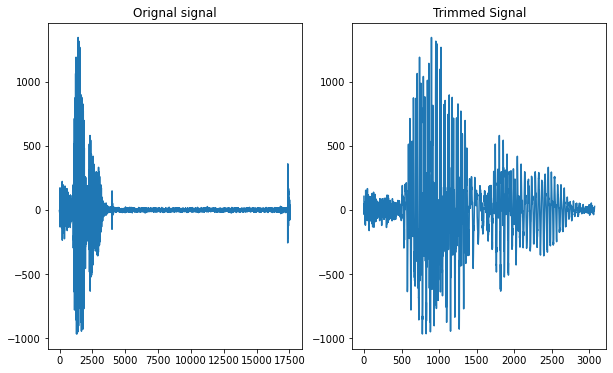

array([106., -31.,  -1., ...,  17.,  14.,  27.])

In [80]:
remove_silence(X[Longest_audio])

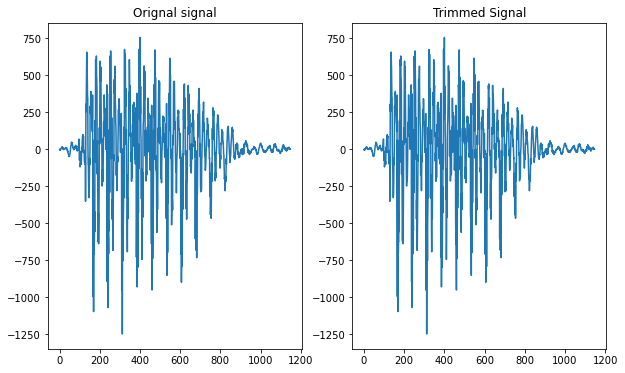

array([-2., -7., -7., ...,  3., -1.,  0.])

In [81]:
remove_silence(X[Shortest_audio])

In [83]:
X_tr = [remove_silence(x) for x in X]

In [85]:
np.argmax([len(x) for x in X_tr])

1419

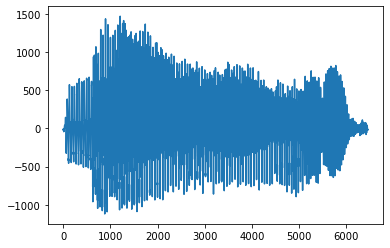

In [96]:
plt.plot(X[1419]);

In [88]:
import IPython.display as ipd

In [94]:
ipd.Audio(X[Longest_audio], rate=8000)

In [95]:
ipd.Audio(X_tr[Longest_audio], rate=8000)

In [97]:
ipd.Audio(X_tr[1419], rate=8000)

In [98]:
N = np.max([len(x) for x in X_tr]) + 1
X_tr_uniform = []
for x in X_tr:
    X_tr_uniform.append(np.pad(x, (0, N - len(x)), constant_values = (0, 0)))


In [104]:
len(y)

3124

In [107]:
X_mean_sd = into_bins(X_tr_uniform, 100)
X_train, X_eval, y_train, y_eval = train_test_split(X_mean_sd, y, test_size = 0.20)
clf = RFC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_eval)
accuracy_score(y_eval, y_pred)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.6014594951815158

In [108]:
X_tr_ft = split_n_compute_mean_std(X_tr, 10)

In [109]:
X_train, X_eval, y_train, y_eval = train_test_split(X_tr_ft, y, test_size = 0.20)
clf = RFC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_eval)
accuracy_score(y_eval, y_pred)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.961280796355374

In [111]:
param_grid = {
    "n_estimators": [50,100,150],
    "criterion": ["gini", "entropy"],
    "min_impurity_decrease": [0.0,0.01,0.2]
}
clf = RFC()
grid_search = GridSearchCV(clf, param_grid, scoring = "f1_macro", cv = 3)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

({'criterion': 'gini', 'min_impurity_decrease': 0.0, 'n_estimators': 150},
 0.9475300538018505)

In [112]:
clf_gs = grid_search.best_estimator_
y_pred = clf_gs.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.9659217010705348

In [113]:
parameteres = {'SVM__C':[5,10,20], 'SVM__kernel':["linear", "poly", "rbf"], 'SVM__gamma':["scale", "auto", 0.1, 0.01]}

X_train, X_eval, y_train, y_eval = train_test_split(X_ft, y, test_size = 0.20)
grid_search = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

({'SVM__C': 5, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'},
 0.9741666666666667)

In [114]:
clf_gs = grid_search.best_estimator_
y_pred = clf_gs.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.9806436326831063